In [1]:
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.decomposition import PCA, KernelPCA

from WISE_tools import plot_confusion_matrix

%matplotlib inline

In [2]:
good = pd.read_csv('../data/bright_sample/massive.csv.gz')
variability_df = pd.read_csv('first_order_statistics.csv')
timescale_df = pd.read_csv('timescales.csv')
classification_df = pd.read_csv('classifications.csv')
joined = good.merge(classification_df,on='source_id')
joined = joined.merge(variability_df,left_on='designation',right_on='WISE_Designation')
joined = joined.merge(timescale_df,left_on='designation',right_on='WISE_Designation')
len(joined),joined.columns

(6484,
 Index(['BP-RP', 'Galaxy', 'M_G', 'M_W1', 'W1-W2', 'W2-W3', 'W3-W4', 'a_g_val',
        'allwise_oid', 'dec', 'designation', 'original_ext_source_id',
        'parallax', 'parallax_error', 'phot_bp_mean_mag', 'phot_g_mean_mag',
        'phot_rp_mean_mag', 'r_est', 'r_hi', 'r_len', 'r_lo', 'ra', 'source_id',
        'w1mpro', 'w1mpro_error', 'w2mpro', 'w2mpro_error', 'w3mpro',
        'w3mpro_error', 'w4mpro', 'w4mpro_error', 'CommonName_x', 'MKType',
        'SimbadOType', 'SpT', 'Jmag', 'e_Jmag', 'Hmag', 'e_Hmag', 'Kmag',
        'e_Kmag', 'G-J', 'J-H', 'H-K', 'K-W1', 'J-W1', 'Unnamed: 0_x',
        'CommonName_y', 'Class', 'CoarseClass', 'IsBinary', 'Unnamed: 0_y',
        'WISE_Designation_x', 'N_obs', 'W1chi2', 'W1chi2red', 'W1_MAD',
        'W1_EWM', 'W2chi2', 'W2chi2red', 'W2_MAD', 'W2_EWM', 'W1-W2chi2',
        'W1-W2chi2red', 'W1-W2_MAD', 'W1-W2_EWM', 'Unnamed: 0',
        'WISE_Designation_y', 'N_visits', 'W1_Nzeroes', 'W1_meanDt', 'W1_stdDt',
        'W2_Nzeroes', 'W2_

In [3]:
#Throw out binaries, plus a single point with bad 2MASS photometry
training_indices =  np.array([i == 0 for i in joined['IsBinary'].values]) & (joined['J-H'] < 2)
training_data = joined[training_indices].fillna(0).reset_index()

#Our features will be color and G/W1 magnitude.
X = training_data[['M_G','G-J','J-H','H-K','K-W1','W1-W2','W2-W3','W3-W4','M_W1','W1chi2red','W2chi2red','W1-W2chi2red',
                   'W1_EWM','W2_EWM','W1-W2_EWM','W1_Nzeroes','W1_meanDt', 'W1_stdDt', 'W2_Nzeroes', 'W2_meanDt',
                   'W2_stdDt','W1-W2_Nzeroes', 'W1-W2_meanDt', 'W1-W2_stdDt']]
labels = training_data['Class']

len(labels)

6377

# Let's try to see what clusters naturally form in the data

In [4]:
#A Bayesian Gaussian Mixture with Infinite Dirichlet Process prior
bgm_param_grid = dict(n_components = [5,10,20,30],
                      covariance_type = ['full', 'tied', 'diag', 'spherical'],
                      weight_concentration_prior_type = ['dirichlet_process','dirichlet_distribution'],
                      weight_concentration_prior = np.logspace(-3,5,9)
                     )
bgm_grid = RandomizedSearchCV(BayesianGaussianMixture(n_init = 5), bgm_param_grid, n_iter = 150, cv=4, n_jobs=-1)                   
bgm_grid.fit(X.values)
best_bgm = bgm_grid.best_estimator_

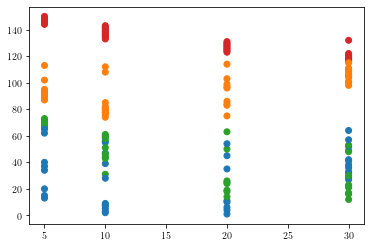

In [5]:
c_dict = {'full':'C0','tied':'C1','diag':'C2','spherical':'C3'}
plt.scatter(bgm_grid.cv_results_['param_n_components'], bgm_grid.cv_results_['rank_test_score'],c=[c_dict[i] for i in bgm_grid.cv_results_['param_covariance_type']])

In [6]:
print(f'Bayesian Gaussian Mixture with {bgm_grid.best_params_}')

Bayesian Gaussian Mixture with {'weight_concentration_prior_type': 'dirichlet_process', 'weight_concentration_prior': 0.001, 'n_components': 20, 'covariance_type': 'full'}


Text(0, 0.5, 'Weight')

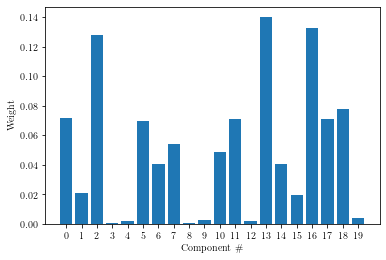

In [7]:
plt.bar(np.arange(best_bgm.n_components),best_bgm.weights_)
plt.xticks(np.arange(best_bgm.n_components))
plt.xlabel('Component \#')
plt.ylabel('Weight')

In [8]:
def plot_ellipses(ax, weights, means, covars):
    for n in range(means.shape[0]):
        eig_vals, eig_vecs = np.linalg.eigh(covars[n])
        unit_eig_vec = eig_vecs[0] / np.linalg.norm(eig_vecs[0])
        angle = np.arctan2(unit_eig_vec[1], unit_eig_vec[0])
        # Ellipse needs degrees
        angle = 180 * angle / np.pi
        # eigenvector normalization
        eig_vals = 2 * np.sqrt(2) * np.sqrt(eig_vals)
        ell = mpl.patches.Ellipse(means[n], eig_vals[0], eig_vals[1],
                                  180 + angle, edgecolor='black')
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(weights[n])
        ell.set_facecolor('#56B4E9')
        ax.add_artist(ell)

In [9]:
def plot_results(ax, estimator, X, col1, col2):
    which_col1 = np.where(X.columns.values == col1)[0][0]
    which_col2 = np.where(X.columns.values == col2)[0][0]
    plot_ellipses(ax, estimator.weights_, estimator.means_[:,[which_col1,which_col2]],
                  estimator.covariances_[:,:,[which_col1,which_col2]][:,[which_col1,which_col2],:])

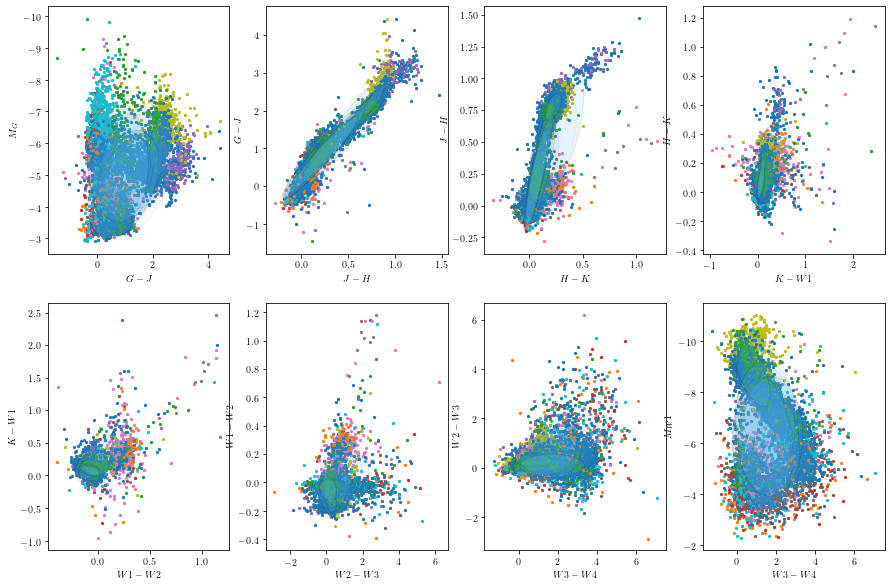

In [10]:
fig, ax = plt.subplots(2,4,figsize=(15,10))
a = ax.flatten()
for i,col in enumerate(X.columns.values[:8]):
    for j,cl in enumerate(np.unique(labels)):
        this_class = X[labels==cl]
        if i != 7:
            a[i].scatter(this_class[f'{X.columns.values[i+1]}'],this_class[f'{col}'],s=5)
            a[i].set(ylabel=f'${col}$',xlabel=f'${X.columns.values[i+1]}$')
        else:
            a[i].scatter(this_class[f'{col}'],this_class[f'{X.columns.values[i+1]}'],s=5,label=cl)
            a[i].set(xlabel=f'${col}$',ylabel=f'${X.columns.values[i+1]}$')
        if i in [0,7]:
            a[i].invert_yaxis()
    if i != 7:
        plot_results(a[i],best_bgm,X,X.columns.values[i+1],col)
    else:
        plot_results(a[i],best_bgm,X,col,X.columns.values[i+1])

In [11]:
test_labels = best_bgm.predict(X)

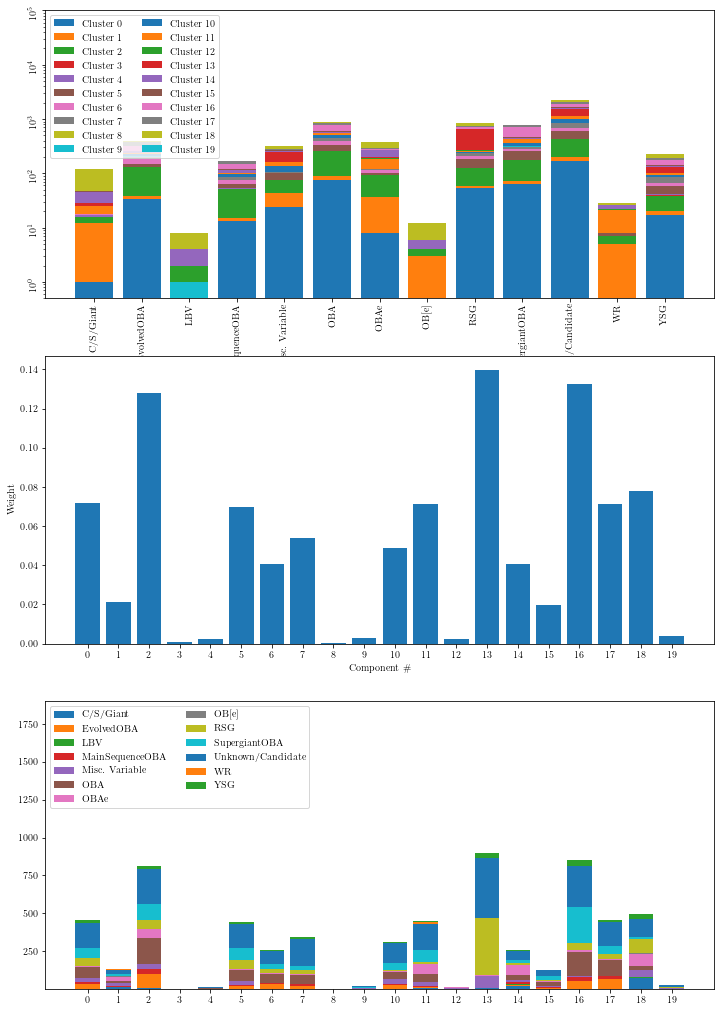

In [12]:
fig, ax = plt.subplots(3, figsize=(12,18))

unique_labels = np.unique(labels)
old_input = np.array([0 for lab in unique_labels])
for i in np.unique(test_labels): #for each identified cluster
    this_cluster = labels[test_labels == i]
    num_input = []
    for lab in unique_labels:
        num = len(this_cluster[this_cluster == lab])
        num_input.append(num)
    ax[0].bar(np.arange(len(unique_labels)),num_input,bottom=old_input,label=f'Cluster {i}')
    old_input += np.array(num_input)
ax[0].set_xticks(np.arange(len(unique_labels)))
ax[0].set_xticklabels(unique_labels)
ax[0].tick_params(labelrotation=90)
ax[0].set_ylim(0.5,1e5)
ax[0].legend(ncol=2,loc='upper left')
ax[0].set_yscale('log')

ax[1].bar(np.arange(best_bgm.n_components),best_bgm.weights_)
ax[1].set_xticks(np.arange(best_bgm.n_components))
ax[1].set_xlabel('Component \#')
ax[1].set_ylabel('Weight')

old_input = np.array([0 for lab in np.unique(test_labels)])
for lab in unique_labels: #for each original label, where do they get classified?
    this_cluster = test_labels[labels == lab]
    num_input = []
    for i in np.unique(test_labels):
        num = len(this_cluster[this_cluster == i])
        num_input.append(num)
    ax[2].bar(np.arange(best_bgm.n_components),num_input,bottom=old_input,label=f'{lab}')
    old_input += np.array(num_input)
ax[2].set_xticks(np.arange(best_bgm.n_components))
ax[2].set_ylim(0.5,1.9e3)
ax[2].legend(ncol=2,loc='upper left')
#ax[2].set_yscale('log')

# Ok, maybe not the best? Let's try to chain together some kind of PCA with the clustering!

In [4]:
n_original_features = len(X.columns)
n_original_features

24

In [5]:
#What features are we going to use? Let's use a PCA, a Kernel PCA, and some of the original
#features to do that!
scaler = StandardScaler()

X_scale = scaler.fit_transform(X)

pca = PCA(n_components=24) #24 linear PCA components
kpca = KernelPCA(n_components=10, n_jobs=-1) #24 KernelPCA components
selection = SelectKBest(k=10) #10 original features

combined_features = FeatureUnion([("pca", pca), ("kpca", kpca), ("univ_select", selection)])

# Use combined features to transform dataset:
X_features = combined_features.fit(X_scale, labels).transform(X_scale)

bgm = BayesianGaussianMixture(n_init = 5, reg_covar=1e-4)

In [6]:
pipeline = Pipeline([("features", combined_features), ("clf", bgm)])


param_grids = [dict(features__pca__n_components = [4, 8, 12, 16, 20, 24],
                       features__pca__whiten = [True,False],
                       features__kpca__kernel = ['linear'],
                       features__univ_select__k = np.arange(n_original_features+1),
                       clf__n_components = [5,10,15],
                       clf__covariance_type = ['full', 'tied', 'diag', 'spherical'],
                       clf__weight_concentration_prior_type = ['dirichlet_process','dirichlet_distribution'],
                       clf__weight_concentration_prior = np.logspace(-3,5,9)),
              dict(features__pca__n_components = [4, 8, 12, 16, 20, 24],
                       features__pca__whiten = [True,False],
                       features__kpca__kernel = ['poly'],
                       features__kpca__coef0 = np.linspace(0,9,11),
                       features__kpca__gamma = np.array([0.01,0.1,1,10]),
                       features__kpca__degree = [2,3,4],
                       features__univ_select__k = np.arange(n_original_features+1),
                       clf__n_components = [5,10,15],
                       clf__covariance_type = ['full', 'tied', 'diag', 'spherical'],
                       clf__weight_concentration_prior_type = ['dirichlet_process','dirichlet_distribution'],
                       clf__weight_concentration_prior = np.logspace(-3,5,9)),
              dict(features__pca__n_components = [4, 8, 12, 16, 20, 24],
                       features__pca__whiten = [True,False],
                       features__kpca__kernel = ['rbf'],
                       features__kpca__gamma = np.array([0.01,0.1,1,10]),
                       features__univ_select__k = np.arange(n_original_features+1),
                       clf__n_components = [5,10,15],
                       clf__covariance_type = ['full', 'tied', 'diag', 'spherical'],
                       clf__weight_concentration_prior_type = ['dirichlet_process','dirichlet_distribution'],
                       clf__weight_concentration_prior = np.logspace(-3,5,9)),
              dict(features__pca__n_components = [4, 8, 12, 16, 20, 24],
                       features__pca__whiten = [True,False],
                       features__kpca__kernel = ['sigmoid'],
                       features__kpca__coef0 = np.linspace(0,9,11),
                       features__kpca__gamma = np.array([0.01,0.1,1,10]),
                       features__univ_select__k = np.arange(n_original_features+1),
                       clf__n_components = [5,10,15],
                       clf__covariance_type = ['full', 'tied', 'diag', 'spherical'],
                       clf__weight_concentration_prior_type = ['dirichlet_process','dirichlet_distribution'],
                       clf__weight_concentration_prior = np.logspace(-3,5,9))
             ]

In [8]:
from tqdm.notebook import tqdm
scores = []
params = []
pipelines = []
for param_grid in tqdm(param_grids):
    print(f'{param_grid["features__kpca__kernel"][0]} kernel')
    this_scores = []
    this_params = []
    this_pipelines = []
    for i in tqdm(range(10)):
        grid = RandomizedSearchCV(pipeline, param_grid, n_iter = 20, cv=4, n_jobs=2, pre_dispatch=2, iid=False, 
                              error_score=-np.inf, verbose=10)        
        grid.fit(X_scale, labels)
        score = grid.score(X_scale, labels)
        param = grid.best_params_
        this_scores.append(score)
        this_params.append(param)
        this_pipelines.append(grid.best_estimator_)
        
    best_score = np.max(this_scores)
    scores.append(best_score)
    print(f'Score = {best_score}')
    
    best_params = this_params[np.argmax(this_scores)]
    params.append(best_params)
    print(f'Best params are {best_params}')
    
    best_pipeline = this_pipelines[np.argmax(this_scores)]
    pipelines.append(best_pipeline)

linear kernel


Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   28.4s
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:   44.7s
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  3.1min
[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  3.9min
[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed:  5.0min
[Parallel(n_jobs=2)]: Done  48 tasks      | elapsed:  6.0min
[Parallel(n_jobs=2)]: Done  59 tasks      | elapsed:  7.7min
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed:  9.0min
[Parallel(n_jobs=2)]: Done

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   34.1s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:   47.9s
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  3.5min
[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  5.0min
[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed:  6.2min
[Parallel(n_jobs=2)]: Done  48 tasks      | elapsed:  7.3min
[Parallel(n_jobs=2)]: Done  59 tasks      | elapsed:  8.8min
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed: 10.1min
[Parallel(n_jobs=2)]: Done

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   32.6s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:   53.3s
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:  2.7min
[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  3.6min
[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  4.5min
[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed:  5.9min
[Parallel(n_jobs=2)]: Done  48 tasks      | elapsed:  7.6min
[Parallel(n_jobs=2)]: Done  59 tasks      | elapsed:  9.9min
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed: 11.8min
[Parallel(n_jobs=2)]: Done

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   27.8s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:   42.3s
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:  1.9min
[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  3.2min
[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  4.1min
[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed:  5.2min
[Parallel(n_jobs=2)]: Done  48 tasks      | elapsed:  6.2min
[Parallel(n_jobs=2)]: Done  59 tasks      | elapsed:  8.5min
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed:  9.9min
[Parallel(n_jobs=2)]: Done

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   27.2s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:   43.4s
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:  2.5min
[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  3.4min
[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  4.1min
[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed:  5.8min
[Parallel(n_jobs=2)]: Done  48 tasks      | elapsed:  7.0min
[Parallel(n_jobs=2)]: Done  59 tasks      | elapsed:  8.2min
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed:  9.6min
[Parallel(n_jobs=2)]: Done

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   28.4s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:   44.0s
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:  1.9min
[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  3.0min
[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  3.9min
[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed:  4.9min
[Parallel(n_jobs=2)]: Done  48 tasks      | elapsed:  6.1min
[Parallel(n_jobs=2)]: Done  59 tasks      | elapsed:  7.5min
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed:  8.8min
[Parallel(n_jobs=2)]: Done

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   30.7s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:   45.7s
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  3.7min
[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  4.5min
[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed:  5.7min
[Parallel(n_jobs=2)]: Done  48 tasks      | elapsed:  6.7min
[Parallel(n_jobs=2)]: Done  59 tasks      | elapsed:  8.5min
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed:  9.8min
[Parallel(n_jobs=2)]: Done

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   32.7s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:   48.8s
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:  2.7min
[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  3.5min
[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  5.0min
[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed:  6.1min
[Parallel(n_jobs=2)]: Done  48 tasks      | elapsed:  7.1min
[Parallel(n_jobs=2)]: Done  59 tasks      | elapsed:  8.6min
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed: 10.0min
[Parallel(n_jobs=2)]: Done

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   26.6s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:   41.9s
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  3.0min
[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  3.7min
[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed:  4.8min
[Parallel(n_jobs=2)]: Done  48 tasks      | elapsed:  5.9min
[Parallel(n_jobs=2)]: Done  59 tasks      | elapsed:  7.5min
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed:  8.9min
[Parallel(n_jobs=2)]: Done

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   49.0s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  1.9min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:  2.7min
[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  3.8min
[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  4.6min
[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed:  6.0min
[Parallel(n_jobs=2)]: Done  48 tasks      | elapsed:  7.8min
[Parallel(n_jobs=2)]: Done  59 tasks      | elapsed: 10.0min
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed: 11.4min
[Parallel(n_jobs=2)]: Done


Score = 100.90347868205752
Best params are {'features__univ_select__k': 23, 'features__pca__whiten': True, 'features__pca__n_components': 24, 'features__kpca__kernel': 'linear', 'clf__weight_concentration_prior_type': 'dirichlet_distribution', 'clf__weight_concentration_prior': 0.01, 'clf__n_components': 10, 'clf__covariance_type': 'full'}
poly kernel


Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   28.3s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:   44.3s
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  3.0min
[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  3.9min
[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed:  4.9min
[Parallel(n_jobs=2)]: Done  48 tasks      | elapsed:  5.9min
[Parallel(n_jobs=2)]: Done  59 tasks      | elapsed:  7.4min
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed:  8.6min
[Parallel(n_jobs=2)]: Done

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   28.4s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:   42.1s
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  3.3min
[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  4.2min
[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed:  5.2min
[Parallel(n_jobs=2)]: Done  48 tasks      | elapsed:  6.2min
[Parallel(n_jobs=2)]: Done  59 tasks      | elapsed:  7.4min
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed:  9.0min
[Parallel(n_jobs=2)]: Done

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   34.3s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:   49.0s
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  3.0min
[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  4.0min
[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed:  5.2min
[Parallel(n_jobs=2)]: Done  48 tasks      | elapsed:  6.2min
[Parallel(n_jobs=2)]: Done  59 tasks      | elapsed:  7.7min
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed:  9.2min
[Parallel(n_jobs=2)]: Done

Fitting 4 folds for each of 20 candidates, totalling 80 fits


/Users/carina/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/base.py:79: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  UserWarning)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   27.8s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:   41.3s
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  2.9min
[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  3.7min
[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed:  5.0min
[

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   25.9s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:   45.4s
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:  1.9min
[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  2.8min
[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  3.5min
[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed:  4.8min
[Parallel(n_jobs=2)]: Done  48 tasks      | elapsed:  5.7min
[Parallel(n_jobs=2)]: Done  59 tasks      | elapsed:  7.0min
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed:  8.2min
[Parallel(n_jobs=2)]: Done

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   32.1s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:   57.7s
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:  2.1min
[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  3.2min
[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  4.4min
[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed:  6.3min
[Parallel(n_jobs=2)]: Done  48 tasks      | elapsed:  7.3min
[Parallel(n_jobs=2)]: Done  59 tasks      | elapsed:  8.6min
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed:  9.9min
[Parallel(n_jobs=2)]: Done

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   35.9s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:   50.7s
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:  2.1min
[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  3.1min
[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  3.9min
[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed:  5.3min
[Parallel(n_jobs=2)]: Done  48 tasks      | elapsed:  6.3min
[Parallel(n_jobs=2)]: Done  59 tasks      | elapsed:  7.9min
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed:  9.7min
[Parallel(n_jobs=2)]: Done

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   27.7s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:   41.3s
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:  1.9min
[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  2.9min
[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  3.7min
[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed:  4.8min
[Parallel(n_jobs=2)]: Done  48 tasks      | elapsed:  6.6min
[Parallel(n_jobs=2)]: Done  59 tasks      | elapsed:  7.7min
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed:  9.0min
[Parallel(n_jobs=2)]: Done

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   58.5s
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  1.9min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:  2.5min
[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  3.3min
[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  4.0min
[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed:  5.3min
[Parallel(n_jobs=2)]: Done  48 tasks      | elapsed:  6.2min
[Parallel(n_jobs=2)]: Done  59 tasks      | elapsed:  7.7min
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed:  8.8min
[Parallel(n_jobs=2)]: Done

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   47.9s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:  1.0min
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  1.9min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:  2.4min
[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  3.2min
[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  3.9min
[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed:  5.1min
[Parallel(n_jobs=2)]: Done  48 tasks      | elapsed:  6.1min
[Parallel(n_jobs=2)]: Done  59 tasks      | elapsed:  7.6min
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed:  9.0min
[Parallel(n_jobs=2)]: Done


Score = 107.42423145619179
Best params are {'features__univ_select__k': 23, 'features__pca__whiten': False, 'features__pca__n_components': 24, 'features__kpca__kernel': 'poly', 'features__kpca__gamma': 0.01, 'features__kpca__degree': 2, 'features__kpca__coef0': 1.8, 'clf__weight_concentration_prior_type': 'dirichlet_process', 'clf__weight_concentration_prior': 0.1, 'clf__n_components': 10, 'clf__covariance_type': 'full'}
rbf kernel


Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   29.7s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:   49.3s
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  3.6min
[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  4.5min
[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed:  5.6min
[Parallel(n_jobs=2)]: Done  48 tasks      | elapsed:  6.6min
[Parallel(n_jobs=2)]: Done  59 tasks      | elapsed:  8.5min
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed:  9.7min
[Parallel(n_jobs=2)]: Done

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   31.8s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:   47.8s
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  3.1min
[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  4.2min
[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed:  5.4min
[Parallel(n_jobs=2)]: Done  48 tasks      | elapsed:  6.4min
[Parallel(n_jobs=2)]: Done  59 tasks      | elapsed:  8.1min
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed:  9.6min
[Parallel(n_jobs=2)]: Done

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:  2.7min
[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  3.8min
[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  5.1min
[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed:  6.7min
[Parallel(n_jobs=2)]: Done  48 tasks      | elapsed:  7.7min
[Parallel(n_jobs=2)]: Done  59 tasks      | elapsed: 10.0min
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed: 11.2min
[Parallel(n_jobs=2)]: Done

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:  2.7min
[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  3.9min
[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  4.7min
[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed:  6.0min
[Parallel(n_jobs=2)]: Done  48 tasks      | elapsed:  7.3min
[Parallel(n_jobs=2)]: Done  59 tasks      | elapsed:  8.9min
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed: 10.3min
[Parallel(n_jobs=2)]: Done

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   27.6s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:   42.7s
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:  2.7min
[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  4.0min
[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  4.8min
[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed:  6.1min
[Parallel(n_jobs=2)]: Done  48 tasks      | elapsed:  7.2min
[Parallel(n_jobs=2)]: Done  59 tasks      | elapsed:  8.6min
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed: 10.5min
[Parallel(n_jobs=2)]: Done

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   26.6s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:   44.2s
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:  2.4min
[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  3.4min
[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  4.6min
[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed:  6.3min
[Parallel(n_jobs=2)]: Done  48 tasks      | elapsed:  7.7min
[Parallel(n_jobs=2)]: Done  59 tasks      | elapsed:  9.3min
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed: 10.8min
[Parallel(n_jobs=2)]: Done

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   27.7s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:  2.8min
[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  4.0min
[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  5.0min
[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed:  6.2min
[Parallel(n_jobs=2)]: Done  48 tasks      | elapsed:  7.3min
[Parallel(n_jobs=2)]: Done  59 tasks      | elapsed:  8.8min
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed: 10.2min
[Parallel(n_jobs=2)]: Done

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   34.0s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:   50.0s
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  2.1min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:  2.7min
[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  3.7min
[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  4.5min
[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed:  5.7min
[Parallel(n_jobs=2)]: Done  48 tasks      | elapsed:  6.7min
[Parallel(n_jobs=2)]: Done  59 tasks      | elapsed:  8.6min
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed: 10.4min
[Parallel(n_jobs=2)]: Done

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   27.8s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:   42.9s
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:  2.1min
[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  2.9min
[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  3.7min
[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed:  5.3min
[Parallel(n_jobs=2)]: Done  48 tasks      | elapsed:  6.7min
[Parallel(n_jobs=2)]: Done  59 tasks      | elapsed:  8.3min
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed:  9.7min
[Parallel(n_jobs=2)]: Done

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   28.5s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:   45.6s
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  2.9min
[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  3.7min
[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed:  5.2min
[Parallel(n_jobs=2)]: Done  48 tasks      | elapsed:  6.7min
[Parallel(n_jobs=2)]: Done  59 tasks      | elapsed:  8.1min
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed:  9.5min
[Parallel(n_jobs=2)]: Done


Score = 105.51292767786855
Best params are {'features__univ_select__k': 24, 'features__pca__whiten': True, 'features__pca__n_components': 24, 'features__kpca__kernel': 'rbf', 'features__kpca__gamma': 10.0, 'clf__weight_concentration_prior_type': 'dirichlet_distribution', 'clf__weight_concentration_prior': 1000.0, 'clf__n_components': 10, 'clf__covariance_type': 'full'}
sigmoid kernel


Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   59.0s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:  2.5min
[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  4.1min
[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  4.9min
[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed:  6.2min
[Parallel(n_jobs=2)]: Done  48 tasks      | elapsed:  7.3min
[Parallel(n_jobs=2)]: Done  59 tasks      | elapsed:  8.6min
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed:  9.9min
[Parallel(n_jobs=2)]: Done

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   27.3s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  2.3min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:  2.8min
[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  3.8min
[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  4.6min
[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed:  6.0min
[Parallel(n_jobs=2)]: Done  48 tasks      | elapsed:  7.0min
[Parallel(n_jobs=2)]: Done  59 tasks      | elapsed:  8.4min
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed:  9.8min
[Parallel(n_jobs=2)]: Done

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   33.7s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:   55.9s
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  3.1min
[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  3.9min
[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed:  5.2min
[Parallel(n_jobs=2)]: Done  48 tasks      | elapsed:  6.2min
[Parallel(n_jobs=2)]: Done  59 tasks      | elapsed:  7.6min
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed:  9.2min
[Parallel(n_jobs=2)]: Done

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   27.6s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:   42.1s
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:  1.9min
[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  2.8min
[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  3.8min
[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed:  5.1min
[Parallel(n_jobs=2)]: Done  48 tasks      | elapsed:  6.1min
[Parallel(n_jobs=2)]: Done  59 tasks      | elapsed:  8.0min
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed:  9.3min
[Parallel(n_jobs=2)]: Done

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   35.8s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:   50.9s
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:  2.1min
[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  3.1min
[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  4.1min
[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed:  6.3min
[Parallel(n_jobs=2)]: Done  48 tasks      | elapsed:  7.4min
[Parallel(n_jobs=2)]: Done  59 tasks      | elapsed:  9.2min
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed: 10.4min
[Parallel(n_jobs=2)]: Done

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   31.0s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:   46.8s
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  3.3min
[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  4.4min
[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed:  5.9min
[Parallel(n_jobs=2)]: Done  48 tasks      | elapsed:  6.9min
[Parallel(n_jobs=2)]: Done  59 tasks      | elapsed:  8.8min
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed: 10.1min
[Parallel(n_jobs=2)]: Done

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   46.9s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:  1.0min
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  4.4min
[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  5.1min
[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed:  6.3min
[Parallel(n_jobs=2)]: Done  48 tasks      | elapsed:  7.2min
[Parallel(n_jobs=2)]: Done  59 tasks      | elapsed:  8.7min
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed:  9.9min
[Parallel(n_jobs=2)]: Done

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   28.3s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:   41.9s
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  1.9min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:  2.3min
[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  3.3min
[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  4.2min
[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed:  5.9min
[Parallel(n_jobs=2)]: Done  48 tasks      | elapsed:  6.9min
[Parallel(n_jobs=2)]: Done  59 tasks      | elapsed:  8.3min
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed:  9.6min
[Parallel(n_jobs=2)]: Done

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   33.7s
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:   49.3s
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:  2.1min
[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  3.3min
[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  4.0min
[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed:  5.2min
[Parallel(n_jobs=2)]: Done  48 tasks      | elapsed:  6.2min
[Parallel(n_jobs=2)]: Done  59 tasks      | elapsed:  8.0min
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed:  9.9min
[Parallel(n_jobs=2)]: Done

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   49.8s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:  2.5min
[Parallel(n_jobs=2)]: Done  23 tasks      | elapsed:  3.7min
[Parallel(n_jobs=2)]: Done  30 tasks      | elapsed:  4.7min
[Parallel(n_jobs=2)]: Done  39 tasks      | elapsed:  6.0min
[Parallel(n_jobs=2)]: Done  48 tasks      | elapsed:  8.1min
[Parallel(n_jobs=2)]: Done  59 tasks      | elapsed:  9.4min
[Parallel(n_jobs=2)]: Done  70 tasks      | elapsed: 10.7min
[Parallel(n_jobs=2)]: Done


Score = 104.0041419585061
Best params are {'features__univ_select__k': 23, 'features__pca__whiten': False, 'features__pca__n_components': 24, 'features__kpca__kernel': 'sigmoid', 'features__kpca__gamma': 0.1, 'features__kpca__coef0': 5.4, 'clf__weight_concentration_prior_type': 'dirichlet_process', 'clf__weight_concentration_prior': 100.0, 'clf__n_components': 5, 'clf__covariance_type': 'full'}



In [9]:
best_params = params[np.argmax(scores)]
print(best_params)
pipeline.set_params(**best_params)
pipeline.fit(X_scale, labels)
test_labels = pipeline.predict(X_scale)

{'features__univ_select__k': 23, 'features__pca__whiten': False, 'features__pca__n_components': 24, 'features__kpca__kernel': 'poly', 'features__kpca__gamma': 0.01, 'features__kpca__degree': 2, 'features__kpca__coef0': 1.8, 'clf__weight_concentration_prior_type': 'dirichlet_process', 'clf__weight_concentration_prior': 0.1, 'clf__n_components': 10, 'clf__covariance_type': 'full'}


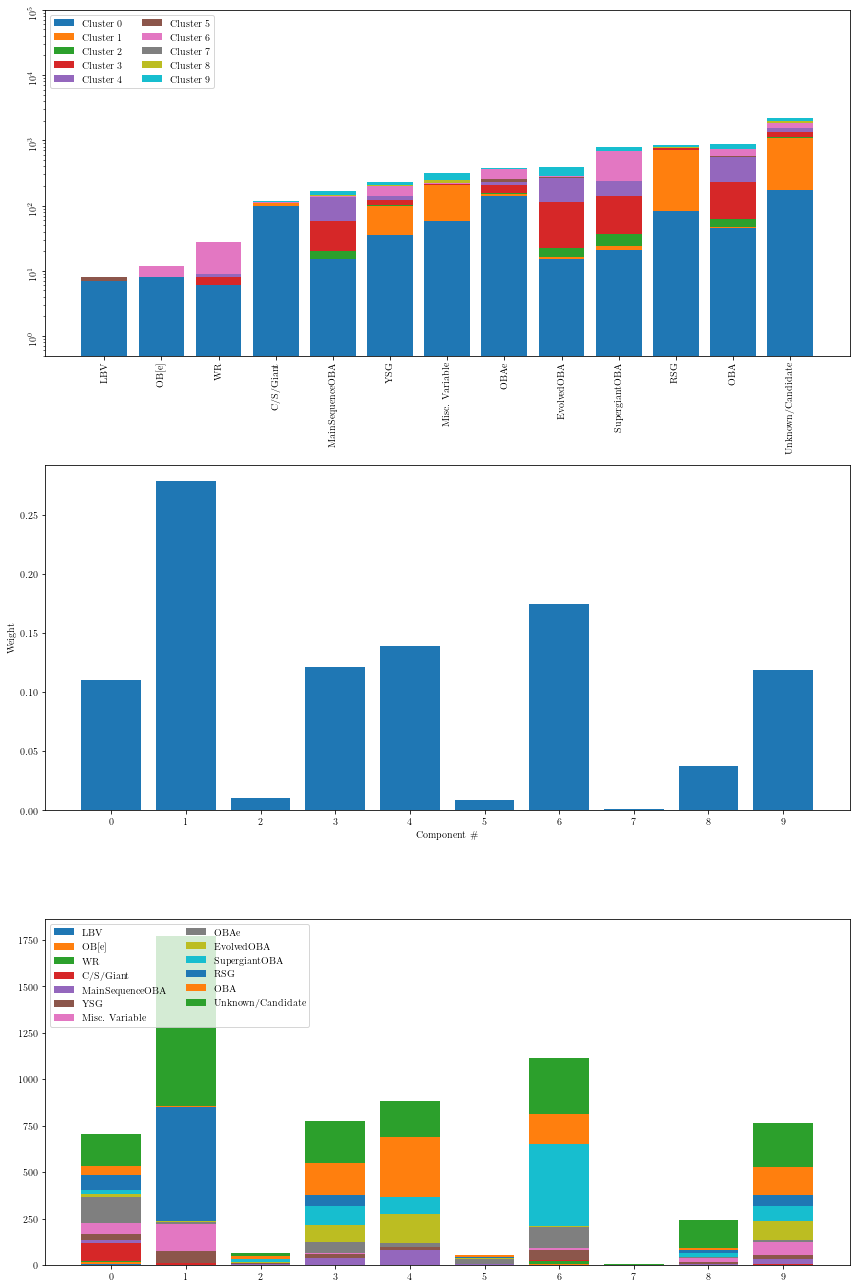

In [10]:
fig, ax = plt.subplots(3, figsize=(12,18))

unique_labels, counts = np.unique(labels, return_counts=True)
sorted_labels = unique_labels[np.argsort(counts)]

clusters = np.arange(pipeline['clf'].n_components)

old_input = np.array([0 for lab in sorted_labels])
for i in clusters: #for each identified cluster
    this_cluster = labels[test_labels == i]
    num_input = []
    for lab in sorted_labels:
        num = len(this_cluster[this_cluster == lab])
        num_input.append(num)
    ax[0].bar(np.arange(len(sorted_labels)),num_input,bottom=old_input,label=f'Cluster {i}')
    old_input += np.array(num_input)
ax[0].set_xticks(np.arange(len(sorted_labels)))
ax[0].set_xticklabels(sorted_labels)
ax[0].tick_params(labelrotation=90)
ax[0].set_ylim(0.5,1e5)
ax[0].legend(ncol=2,loc='upper left')
ax[0].set_yscale('log')

ax[1].bar(clusters,pipeline['clf'].weights_)
ax[1].set_xticks(clusters)
ax[1].set_xlabel('Component \#')
ax[1].set_ylabel('Weight')

old_input = np.array([0 for lab in clusters])
for lab in sorted_labels: #for each original label, where do they get classified?
    this_cluster = test_labels[labels == lab]
    num_input = []
    for i in clusters:
        num = len(this_cluster[this_cluster == i])
        num_input.append(num)
    ax[2].bar(clusters,num_input,bottom=old_input,label=f'{lab}')
    old_input += np.array(num_input)
ax[2].set_xticks(clusters)
#ax[2].set_ylim(0.5,1.9e3)
ax[2].legend(ncol=2,loc='upper left')
#ax[2].set_yscale('log')
plt.tight_layout()